In [1]:
import torch
import torch.nn.functional as F

In [2]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
loadstr = '/home/bstadt/root/tlm/models/tlm-2025-08-05_16-42-11/checkpoint-10500/'
model = AutoModelForMaskedLM.from_pretrained(loadstr)
tokenizer = AutoTokenizer.from_pretrained(loadstr)

/home/bstadt/root/tlm/tlmenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def get_top_fills(phrase, model, tokenizer, top_k=5):
    """
    Get the top k most likely fills for a phrase with mask tokens.
    
    Args:
        phrase: String with [MASK] tokens to fill
        model: The language model
        tokenizer: The tokenizer
        top_k: Number of top fills to return (default 5)
    
    Returns:
        List of tuples (fill_tokens, probability) for top k fills
    """
    model.eval()
    
    # Tokenize and find mask positions
    inputs = tokenizer.encode_plus(phrase, add_special_tokens=False, return_tensors='pt')
    mask_locs = torch.where(inputs['input_ids'] == tokenizer.mask_token_id)[1]
    n_masks = len(mask_locs)
    
    if n_masks == 0:
        raise ValueError("No mask tokens found in phrase")
    
    device = model.device
    with torch.no_grad():
        inputs = {k: v.to(device) for k, v in inputs.items()}
        outputs = model(**inputs)
        logits = outputs.logits[0]  # Remove batch dimension
        
        # Get logits for each mask position
        mask_logits = logits[mask_locs]  # Shape: (n_masks, vocab_size)
        
        # Convert to probabilities
        mask_probs = F.softmax(mask_logits, dim=-1)
        
        # For multiple masks, we need to consider combinations
        if n_masks == 1:
            # Single mask case
            top_probs, top_indices = torch.topk(mask_probs[0], top_k)
            results = []
            for prob, idx in zip(top_probs, top_indices):
                token = tokenizer.decode([idx.item()])
                results.append((token, prob.item()))
            return results
        
        else:
            # Multiple masks - get top tokens for each position and combine
            # This is a simplified approach - for exact top-k we'd need beam search
            top_tokens_per_mask = []
            for i in range(n_masks):
                top_probs_i, top_indices_i = torch.topk(mask_probs[i], top_k)
                top_tokens_per_mask.append([(tokenizer.decode([idx.item()]), prob.item()) 
                                          for prob, idx in zip(top_probs_i, top_indices_i)])
            
            # Generate combinations and compute joint probabilities
            from itertools import product
            combinations = list(product(*top_tokens_per_mask))
            
            results = []
            for combo in combinations:
                tokens = [token for token, _ in combo]
                joint_prob = np.prod([prob for _, prob in combo])
                fill_text = ' '.join(tokens)
                results.append((fill_text, joint_prob))
            
            # Sort by probability and return top k
            results.sort(key=lambda x: x[1], reverse=True)
            return results[:top_k]


In [4]:
years = list(range(1990, 2020))
year_fills = ['[YEAR:{}]'.format(year) for year in years]
year_fill_token_ids = [tokenizer.encode(e)[1] for e in year_fills]
def lyear(phrase, model, tokenizer):
    year_template = '[MASK] ' + phrase
    input_ids = tokenizer.encode(year_template, add_special_tokens=False, return_tensors='pt')
    input_ids = input_ids.to('cuda')
    with torch.no_grad():
        outputs = model(input_ids=input_ids)
        logits = outputs.logits[0][0]
        year_sublogits = logits[year_fill_token_ids]
        year_subprobs = F.softmax(year_sublogits, dim=0)

    return years, year_sublogits, year_subprobs

In [5]:
def load_uses(uses_path, word):
    with open(uses_path, 'r', encoding='utf-8') as f:
        uses_data = f.readlines()

    uses_data = [line.strip() for line in uses_data if line.strip()]

    print(f"Loaded {len(uses_data)} lines from {uses_path}")

    import re
    uses_data = [text for text in uses_data if re.search(r'\b{}\b'.format(word), text)]
    print(f"Filtered to {len(uses_data)} sentences containing the word '{word}'")

    use_loc = uses_data[0].index(word)
    print(uses_data[0][use_loc-50:use_loc+50])
    get_top_fills(uses_data[0].replace(word, '[MASK]'), model, tokenizer)

    return uses_data


In [6]:
import re
def strip_year(text):
    #removes the year token and returns the year as an int, as well as the text without the year token
    year_pattern = r'\[YEAR:(\d+)\]'
    year = re.search(year_pattern, text)
    if year:
        return int(year.group(1)), re.sub(year_pattern, '', text)
    else:
        return None, text


In [7]:
import numpy as np
from tqdm import tqdm
def get_posterior(phrase, model, tokenizer, exclude_text=None):
    nucleus = [fill[0] for fill in get_top_fills(phrase, model, tokenizer, top_k=10)]
    if exclude_text:
        nucleus = [fill for fill in nucleus if exclude_text not in fill]
    _, _, template_year_subprobs = lyear(phrase, model, tokenizer)
    bayes_by_fill = []
    for fill in nucleus:
        filled_phrase = phrase.replace('[MASK]', fill)
        years, _, fill_probs = lyear(filled_phrase, model, tokenizer)
        bayes_factors = fill_probs/template_year_subprobs
        bayes_by_fill.append(bayes_factors.detach().cpu().numpy())

    posterior = np.stack(bayes_by_fill).T/np.sum(bayes_by_fill, axis=0, keepdims=True).T
    return nucleus, posterior


In [8]:
from collections import defaultdict
def aggregate_posteriors(posteriors):
    word_to_mass = defaultdict(float)
    for posterior in posteriors:
        for word, mass in zip(posterior['nucleus'], posterior['posterior']):
            word_to_mass[word] += mass
    #uniform dist over documents
    aggregated_posterior = {word: mass/len(posteriors) for word, mass in word_to_mass.items()}
    return aggregated_posterior


In [9]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_graph(matrix, wordlist):
    
    # Create a graph from the matrix
    G = nx.Graph()

    # Add nodes
    for word in wordlist:
        G.add_node(word)

    # Add edges based on the matrix (only add edges with significant weights)
    threshold = 0.00  # Adjust this threshold as needed
    for i in range(len(wordlist)):
        for j in range(i+1, len(wordlist)):
            if matrix[i, j] > threshold:
                G.add_edge(wordlist[i], wordlist[j], weight=matrix[i, j])

    from sklearn.decomposition import PCA

    pca = PCA(n_components=2, random_state=42)
    pca_coords = pca.fit_transform(matrix)

    # Create initial positions dictionary from PCA coordinates
    initial_pos = {node: pca_coords[i] for i, node in enumerate(wordlist)}

    # Create force-directed layout with better parameters for dense areas
    pos = nx.spring_layout(G, k=4, iterations=50000, seed=42, scale=6, pos=initial_pos)
    
    # Post-process to nforce minimum distance between nodes
    def enforce_min_distance(pos, min_dist=0.15):
        """Adjust positions to ensure minimum distance between any two nodes"""
        import numpy as np
        nodes = list(pos.keys())
        positions = np.array([pos[node] for node in nodes])
        
        # Iteratively adjust positions that are too close
        max_iterations = 100
        for iteration in range(max_iterations):
            moved = False
            for i in range(len(nodes)):
                for j in range(i + 1, len(nodes)):
                    diff = positions[i] - positions[j]
                    dist = np.linalg.norm(diff)
                    
                    if dist < min_dist and dist > 0:
                        # Calculate how much to move apart
                        move_dist = (min_dist - dist) / 2
                        direction = diff / dist
                        
                        # Move both nodes apart
                        positions[i] += direction * move_dist
                        positions[j] -= direction * move_dist
                        moved = True
            
            if not moved:
                break
        
        # Update the position dictionary
        return {nodes[i]: positions[i] for i in range(len(nodes))}
    
    pos = enforce_min_distance(pos, min_dist=1.5)

    # Create the plot
    plt.figure(figsize=(15, 12))

    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.5)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color='lightblue', alpha=0.7)

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

    plt.title('Force-Directed Network Visualization of Word-Cell Matrix')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    return G, pos


In [10]:
def write_interactive_plot(G, pos, word):
    # save as ego_plotly_hover.py and run
    import json
    import networkx as nx
    import plotly.graph_objects as go
    import plotly.io as pio

    # Define the color palette
    good_colors = ['#EA5526', '#4462BD', '#51915B', '#8064A2', '#E5B700']

    # -----------------------
    # 1) build a sample graph
    # -----------------------

    # Remove edges between time bucket nodes (nodes like word:<timebucket>)
    edges_to_remove = []
    for u, v in G.edges():
        # Check if both nodes are time bucket nodes (contain word and have colon)
        u_is_time_node = word in str(u) and ':' in str(u)
        v_is_time_node = word in str(v) and ':' in str(v)
        
        if u_is_time_node and v_is_time_node:
            edges_to_remove.append((u, v))
    
    # Remove the identified edges
    G.remove_edges_from(edges_to_remove)
    
    nodes = list(G.nodes())
    node_index = {n: i for i, n in enumerate(nodes)}
    n_nodes = len(nodes)

    # adjacency list as list-of-lists indexed by node index
    adj = [[] for _ in range(n_nodes)]
    for u, v in G.edges():
        ui, vi = node_index[u], node_index[v]
        adj[ui].append(vi)
        adj[vi].append(ui)

    # prepare edge segments grouped by which node they touch
    edges_by_node = [[] for _ in range(n_nodes)]
    edge_segments = []  # all edges (for base faint edges)
    for u, v in G.edges():
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        edge_segments.append(((x0, x1, None), (y0, y1, None)))  # None creates breaks between segments
        ui, vi = node_index[u], node_index[v]
        edges_by_node[ui].append((x0, x1, y0, y1))
        edges_by_node[vi].append((x0, x1, y0, y1))

    # flatten for base edge trace
    edge_x = []
    edge_y = []
    for xs, ys in edge_segments:
        edge_x.extend(xs)
        edge_y.extend(ys)

    # node coordinates
    node_x = [pos[n][0] for n in nodes]
    node_y = [pos[n][1] for n in nodes]
    node_text = [str(n) for n in nodes]

    # -----------------------
    # 2) create plotly traces
    # -----------------------
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        mode='lines',
        line=dict(width=1, color='#CCCCCC'),
        hoverinfo='none',
        opacity=0.3,
        name='edges'
    )

    # trace that will hold highlighted edges (initially empty)
    highlight_edge_trace = go.Scatter(
        x=[], y=[],
        mode='lines',
        line=dict(width=2, color='#6B79A3'),  # Thicker but same color as regular edges
        hoverinfo='none',
        opacity=0.3,
        name='highlight_edges'
    )

    # Invisible node trace for hover detection only
    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        marker=dict(size=20, color='rgba(0,0,0,0)', opacity=0),  # Invisible markers
        hoverinfo='none',  # Remove tooltips
        text=node_text,
        name='nodes',
        customdata=list(range(n_nodes))  # handy to get index in JS
    )

    # Background rectangles for text (will be added via shapes in layout)
    # We'll create these dynamically based on text positions

    # Determine which nodes should be bolded (contain the word)
    text_weights = []
    word_containing_indices = []
    for i, text in enumerate(node_text):
        if word in str(text):
            text_weights.append('bold')
            word_containing_indices.append(i)
        else:
            text_weights.append('normal')

    # Text trace for node labels - now the main visual element
    text_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='text',
        text=node_text,
        textfont=dict(size=18, color='black', family='Geist Mono'),
        hoverinfo='none',  # Remove tooltips
        name='text',
        showlegend=False
    )

    # Create background rectangles for each text label
    text_backgrounds = []
    for i, (x, y, text) in enumerate(zip(node_x, node_y, node_text)):
        # Estimate text width and height (rough approximation)
        text_width = len(str(text)) * 0.011  # Approximate character width in plot coordinates
        text_height = 0.025  # Approximate text height in plot coordinates
        
        text_backgrounds.append(dict(
            type="rect",
            x0=x - text_width/2,
            y0=y - text_height/2,
            x1=x + text_width/2,
            y1=y + text_height/2,
            fillcolor="#FDF6E8",
            line=dict(width=0),
            layer="below"
        ))

    # Extract time buckets from word-containing nodes and sort them
    time_buckets = []
    bucket_to_indices = {}
    for i, text in enumerate(node_text):
        if word in str(text) and ':' in str(text):
            # Extract the time range part (e.g., "1990-1995" from "cell:1990-1995")
            time_part = str(text).split(':')[1]
            if time_part not in time_buckets:
                time_buckets.append(time_part)
                bucket_to_indices[time_part] = []
            bucket_to_indices[time_part].append(i)
    
    # Sort time buckets chronologically
    time_buckets.sort(key=lambda x: int(x.split('-')[0]))
    
    # Create slider steps
    slider_steps = []
    slider_steps.append({
        'args': [{'textfont.color': [['black'] * len(node_text)]}, [3]],
        'label': 'None',
        'method': 'restyle'
    })
    
    for bucket in time_buckets:
        colors = ['black'] * len(node_text)
        # Highlight the time bucket nodes and their ego networks
        highlighted_indices = set()
        for idx in bucket_to_indices[bucket]:
            colors[idx] = '#EA5526'  # Orange highlight color for the main node
            highlighted_indices.add(idx)
            # Add neighbors to highlighting
            for neighbor_idx in adj[idx]:
                colors[neighbor_idx] = '#EA5526'
                highlighted_indices.add(neighbor_idx)
        
        slider_steps.append({
            'args': [{'textfont.color': [colors]}, [3]],
            'label': bucket,
            'method': 'restyle'
        })

    fig = go.Figure(data=[edge_trace, highlight_edge_trace, node_trace, text_trace],
                    layout=go.Layout(
                        showlegend=False,
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        hovermode='closest',
                        margin=dict(b=50, l=0, r=0, t=0),  # Increased bottom margin for slider
                        plot_bgcolor='#FDF6E8',
                        paper_bgcolor='#FDF6E8',
                        font=dict(family='Geist Mono'),
                        shapes=text_backgrounds,
                        width=1000,
                        height=750,  # Increased height for slider
                        sliders=[{
                            'active': 0,
                            'currentvalue': {'visible': False},  # Remove time period annotation
                            'pad': {'t': 20, 'b': 10},  # Reduced padding to make slider smaller
                            'len': 0.8,  # Make slider shorter (80% of plot width)
                            'x': 0.1,  # Center the slider
                            'bgcolor': '#CCCCCC',  # Background track stays gray
                            'bordercolor': '#CCCCCC',
                            'tickcolor': '#CCCCCC',  # Slider button/thumb color
                            'steps': slider_steps
                        }]
                    ))

    # -----------------------
    # 3) produce HTML and inject JS for hover behavior
    # -----------------------
    # Unique div id so we can target the plotly div in the JS
    div_id = "ego-network-plot"

    # adjacency and edges_by_node must be serializable to JS
    adj_json = json.dumps(adj)
    # For edges_by_node, create lists of segment coordinates as pairs to simplify JS handling
    edges_by_node_js = []
    for segs in edges_by_node:
        # segs is list of (x0,x1,y0,y1)
        segs_js = [[x0, x1, y0, y1] for (x0, x1, y0, y1) in segs]
        edges_by_node_js.append(segs_js)
    edges_by_node_json = json.dumps(edges_by_node_js)
    
    # Prepare data for slider interaction
    bucket_to_indices_json = json.dumps(bucket_to_indices)
    node_text_json = json.dumps(node_text)
    word_json = json.dumps(word)

    # Build client-side JS: attaches to plot's div, listens for plotly_hover & plotly_unhover,
    # updates node colors and the highlight-edge trace.
    injected_js = f"""
    <script>
    (function(){{
    const adj = {adj_json};
    const edges_by_node = {edges_by_node_json};
    const goodColors = {json.dumps(good_colors)};
    const bucketToIndices = {bucket_to_indices_json};
    const nodeText = {node_text_json};
    const targetWord = {word_json};

    const gd = document.getElementById('{div_id}');
    if(!gd) return;

    let currentSliderState = null;  // Track current slider highlighting
    let isHovering = false;  // Track if we're currently hovering

    // helper to get current slider colors based on active slider step
    function getSliderColors() {{
        if(!gd.layout || !gd.layout.sliders || !gd.layout.sliders[0]) {{
            return new Array(adj.length).fill('black');
        }}
        
        const activeStep = gd.layout.sliders[0].active;
        const steps = gd.layout.sliders[0].steps;
        
        if(activeStep === 0) {{
            // "None" option selected
            return new Array(adj.length).fill('black');
        }}
        
        const selectedLabel = steps[activeStep].label;
        const colors = new Array(adj.length).fill('black');
        
        if(bucketToIndices[selectedLabel]) {{
            // Highlight the time bucket nodes and their ego networks
            const highlightedIndices = new Set();
            bucketToIndices[selectedLabel].forEach(idx => {{
                colors[idx] = '#EA5526';  // Orange highlight color for main node
                highlightedIndices.add(idx);
                // Add neighbors to highlighting
                adj[idx].forEach(neighborIdx => {{
                    colors[neighborIdx] = '#EA5526';
                    highlightedIndices.add(neighborIdx);
                }});
            }});
        }}
        
        return colors;
    }}

    // helper to set text colors for hover (overrides slider)
    function colorTextHover(hoverIndex) {{
        const colors = new Array(adj.length).fill('black');
        if(hoverIndex !== null) {{
            colors[hoverIndex] = '#EA5526';  // Orange color from palette
            adj[hoverIndex].forEach(i => colors[i] = '#EA5526');
        }}
        // update the text trace (trace index 3)
        Plotly.restyle(gd, {{'textfont.color': [colors]}}, [3]);
    }}

    // helper to get highlighted edges for slider
    function getSliderHighlightedEdges() {{
        if(!gd.layout || !gd.layout.sliders || !gd.layout.sliders[0]) {{
            return [];
        }}
        
        const activeStep = gd.layout.sliders[0].active;
        const steps = gd.layout.sliders[0].steps;
        
        if(activeStep === 0) {{
            // "None" option selected
            return [];
        }}
        
        const selectedLabel = steps[activeStep].label;
        let allEdges = [];
        
        if(bucketToIndices[selectedLabel]) {{
            bucketToIndices[selectedLabel].forEach(idx => {{
                // Only add edges directly connected to this time bucket node (one hop)
                const segs = edges_by_node[idx];
                segs.forEach(s => {{
                    allEdges.push(s);
                }});
            }});
        }}
        
        return allEdges;
    }}

    // helper to restore slider colors and edges (when not hovering)
    function restoreSliderColors() {{
        const colors = getSliderColors();
        Plotly.restyle(gd, {{'textfont.color': [colors]}}, [3]);
        
        // Also restore slider edge highlighting
        const sliderEdges = getSliderHighlightedEdges();
        let xs = [], ys = [];
        sliderEdges.forEach(s => {{
            xs.push(s[0]); xs.push(s[1]); xs.push(null);
            ys.push(s[2]); ys.push(s[3]); ys.push(null);
        }});
        Plotly.restyle(gd, {{x:[xs], y:[ys]}}, [1]);
    }}

    // helper to show edges connected to hoverIndex in trace index 1
    function showHighlightEdges(hoverIndex) {{
        if(hoverIndex === null) {{
            Plotly.restyle(gd, {{x:[[]], y:[[]]}}, [1]);
            return;
        }}
        const segs = edges_by_node[hoverIndex]; // [[x0,x1,y0,y1], ...]
        // Flatten into x and y arrays with None breaks
        let xs = [], ys = [];
        segs.forEach(s => {{
            xs.push(s[0]); xs.push(s[1]); xs.push(null);
            ys.push(s[2]); ys.push(s[3]); ys.push(null);
        }});
        Plotly.restyle(gd, {{x:[xs], y:[ys]}}, [1]);
    }}

    gd.on('plotly_hover', function(eventData) {{
        const pt = eventData.points && eventData.points[0];
        if(!pt) return;
        // Handle hover on either the invisible node trace or text trace
        if(pt.fullData && (pt.fullData.name === 'nodes' || pt.fullData.name === 'text')) {{
            const idx = pt.pointIndex;
            isHovering = true;
            colorTextHover(idx);
            showHighlightEdges(idx);
        }}
    }});

    gd.on('plotly_unhover', function(eventData) {{
        isHovering = false;
        restoreSliderColors();  // Return to slider highlighting (includes edges)
    }});

    // Listen for slider changes to update our tracking
    gd.on('plotly_sliderchange', function(eventData) {{
        if(!isHovering) {{
            // Only update colors if we're not currently hovering
            restoreSliderColors();
        }}
    }});

    // Set initial text colors based on word containment (bold effect)
    function setInitialTextStyles() {{
        const weights = nodeText.map(text => 
            text.includes(targetWord) ? 'bold' : 'normal'
        );
        Plotly.restyle(gd, {{'textfont.weight': [weights]}}, [3]);
        
        // Also set initial colors
        restoreSliderColors();
    }}

    // Initialize
    setInitialTextStyles();
    }})();
    </script>
    """

    # Configuration to remove Plotly logo
    config = {
        'displayModeBar': False,
        'displaylogo': False,
    }

    # get HTML string with config
    html_str = pio.to_html(fig, full_html=True, include_plotlyjs='cdn', div_id=div_id, config=config)
    # append injected JS before closing </body>
    html_str = html_str.replace("</body>", injected_js + "</body>")

    out_path = "{}_network_plot.html".format(word)
    with open(out_path, "w", encoding="utf-8") as f:
        f.write(html_str)

    print(f"Wrote interactive ego-network HTML to: {out_path}")


In [11]:
def paradigmic_change(target_word, uses_path, model, tokenizer, subset_size=300):

    #load data
    uses_data = load_uses(uses_path, target_word)

    #random subset
    import random
    random.seed(42) 
    selected_indices = random.sample(range(len(uses_data)), min(subset_size, len(uses_data)))
    masked_texts = [uses_data[i].replace(target_word, '[MASK]', 1) for i in selected_indices]

    #move model here to prevent weird cuda memory errors
    model = model.to('cuda')

    #get posteriors
    posteriors_by_year = {k: [] for k in range(1990, 2020)}
    for text in tqdm(masked_texts):
        year, text = strip_year(text)
        if year:
            nucleus, posterior = get_posterior(text, model, tokenizer)
            posteriors_by_year[year].append({'nucleus': nucleus, 'posterior': posterior[year-1990], 'text':text})

    #aggregate posteriors
    aggregated_posteriors = {}
    for year_bucket_start in range(1990, 2020, 5):
        years_in_bucket = [year for year in range(year_bucket_start, year_bucket_start+5) if year in posteriors_by_year]
        bucket_posteriors = []
        for year in years_in_bucket:
            bucket_posteriors.extend(posteriors_by_year[year])
        
        aggregated_posterior = aggregate_posteriors(bucket_posteriors)
        aggregated_posteriors[year_bucket_start] = aggregated_posterior

    #top words by bucket
    top_words_by_bucket = {}
    for year_bucket, posterior in aggregated_posteriors.items():
        # Sort by posterior probability and get top 20
        filtered = {k: v for k, v in posterior.items() if 'cell' not in k.lower()}
        filtered = {k: v for k, v in filtered.items() if sum(c.isalpha() for c in k) >= 2}

        sorted_words = sorted(filtered.items(), key=lambda x: x[1], reverse=True)[:15]
        top_words_by_bucket[year_bucket] = sorted_words

    #create wordlist
    wordset = set()
    for year_bucket, posterior in top_words_by_bucket.items():
        for elem in posterior:
            wordset.add(elem[0])
    og_wordlist = list(wordset)
    wordlist = og_wordlist + [target_word+':'+str(year)+'-'+str(year+5) for year in range(1990, 2020, 5)]

    #create use matrix
    bipartite = np.zeros((len(wordlist) - len(og_wordlist), len(og_wordlist)))
    for i, year in enumerate(top_words_by_bucket.keys()):
        posterior = top_words_by_bucket[year]
        for e in posterior:
            word = e[0]
            mass = e[1]
            if word in og_wordlist:
                bipartite[i, og_wordlist.index(word)] = mass

    wordsims = bipartite @ bipartite.T  # shape: (num_U_nodes, num_U_nodes)

    matrix = np.zeros((len(wordlist), len(wordlist)))
    matrix[len(og_wordlist):, len(og_wordlist):] = wordsims
    matrix[len(og_wordlist):, :len(og_wordlist)] = bipartite
    matrix[:len(og_wordlist), len(og_wordlist):] = bipartite.T

    #create and plot graph
    G, pos = plot_graph(matrix, wordlist)


    #write interactive plot
    write_interactive_plot(G, pos, target_word)

    return G, pos, matrix

Loaded 45587 lines from mined_usages/cell_uses.txt
Filtered to 42990 sentences containing the word 'cell'
il. The naked dead, all in [MASK_NOLOSS] the jail cell. They said nothing. But they were mute with d


100%|██████████| 300/300 [03:50<00:00,  1.30it/s]


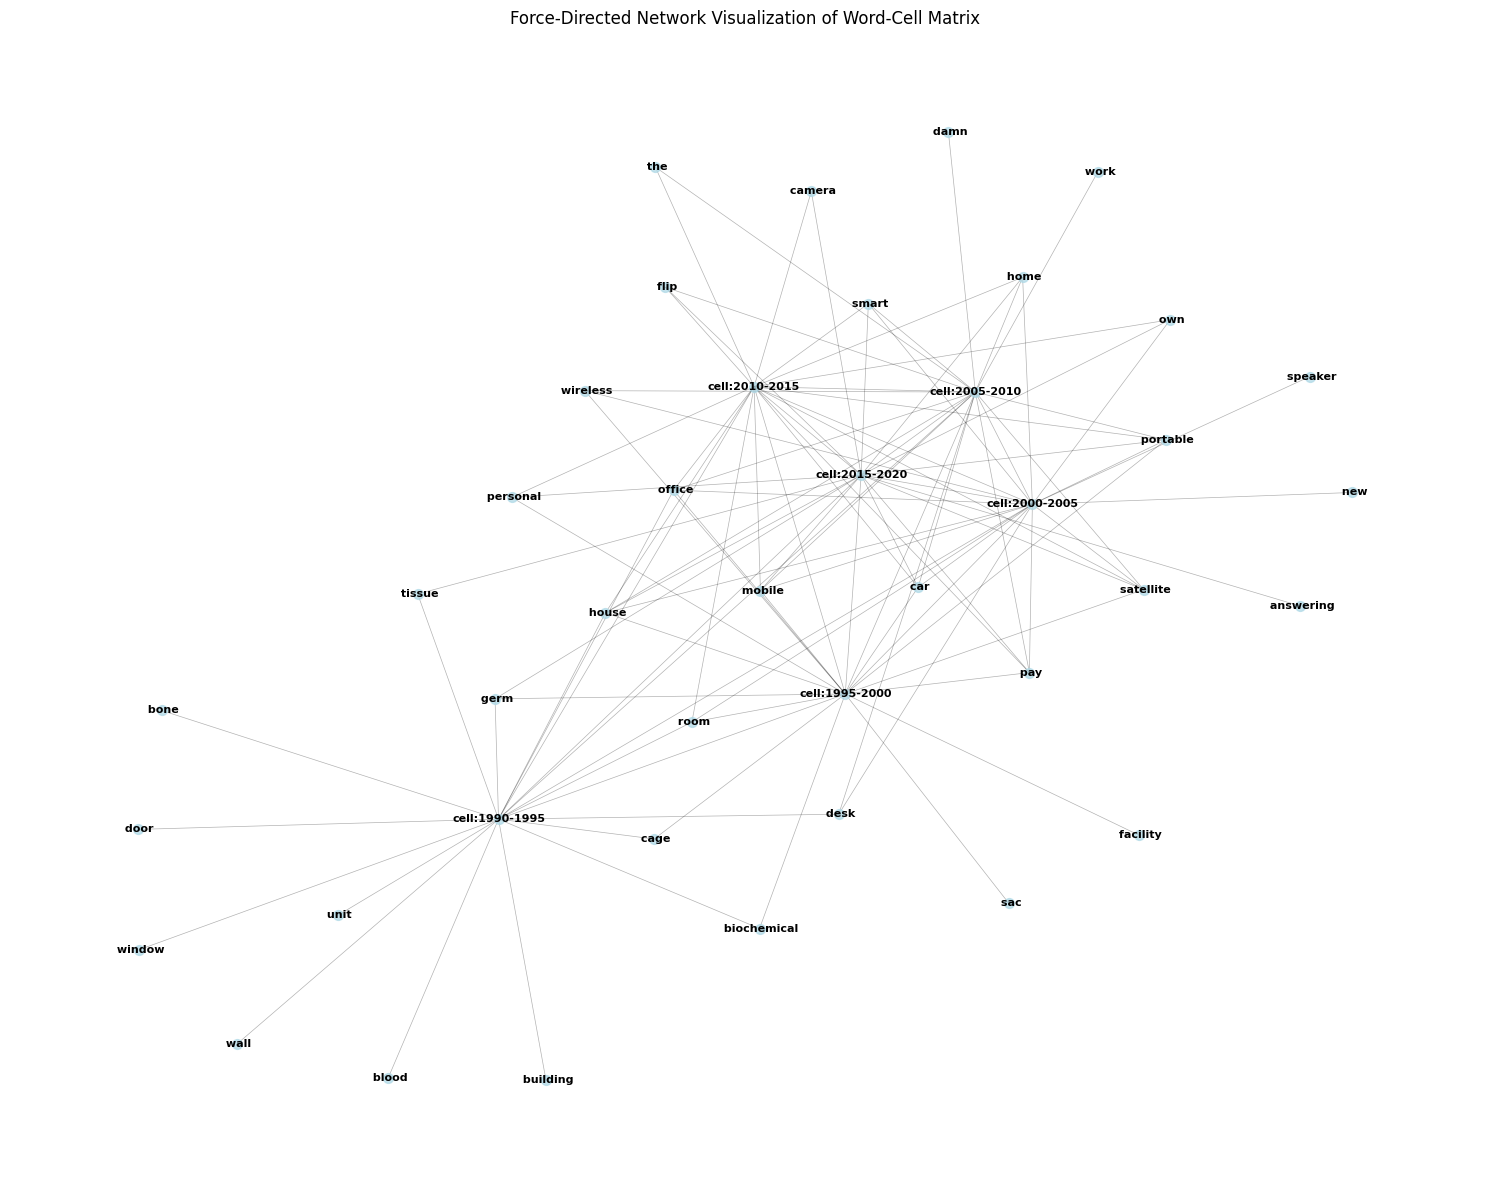

Wrote interactive ego-network HTML to: cell_network_plot.html


In [13]:
cell_G, cell_pos, cell_matrix = paradigmic_change('cell', 'mined_usages/cell_uses.txt', model, tokenizer, subset_size=300)

Loaded 115053 lines from mined_usages/seven_uses.txt
Filtered to 102403 sentences containing the word 'seven'
earing a big unusual hat that must have given her seven feet in height. She was looking toward my fr


 23%|██▎       | 68/300 [00:52<03:00,  1.29it/s]

100%|██████████| 300/300 [03:53<00:00,  1.28it/s]


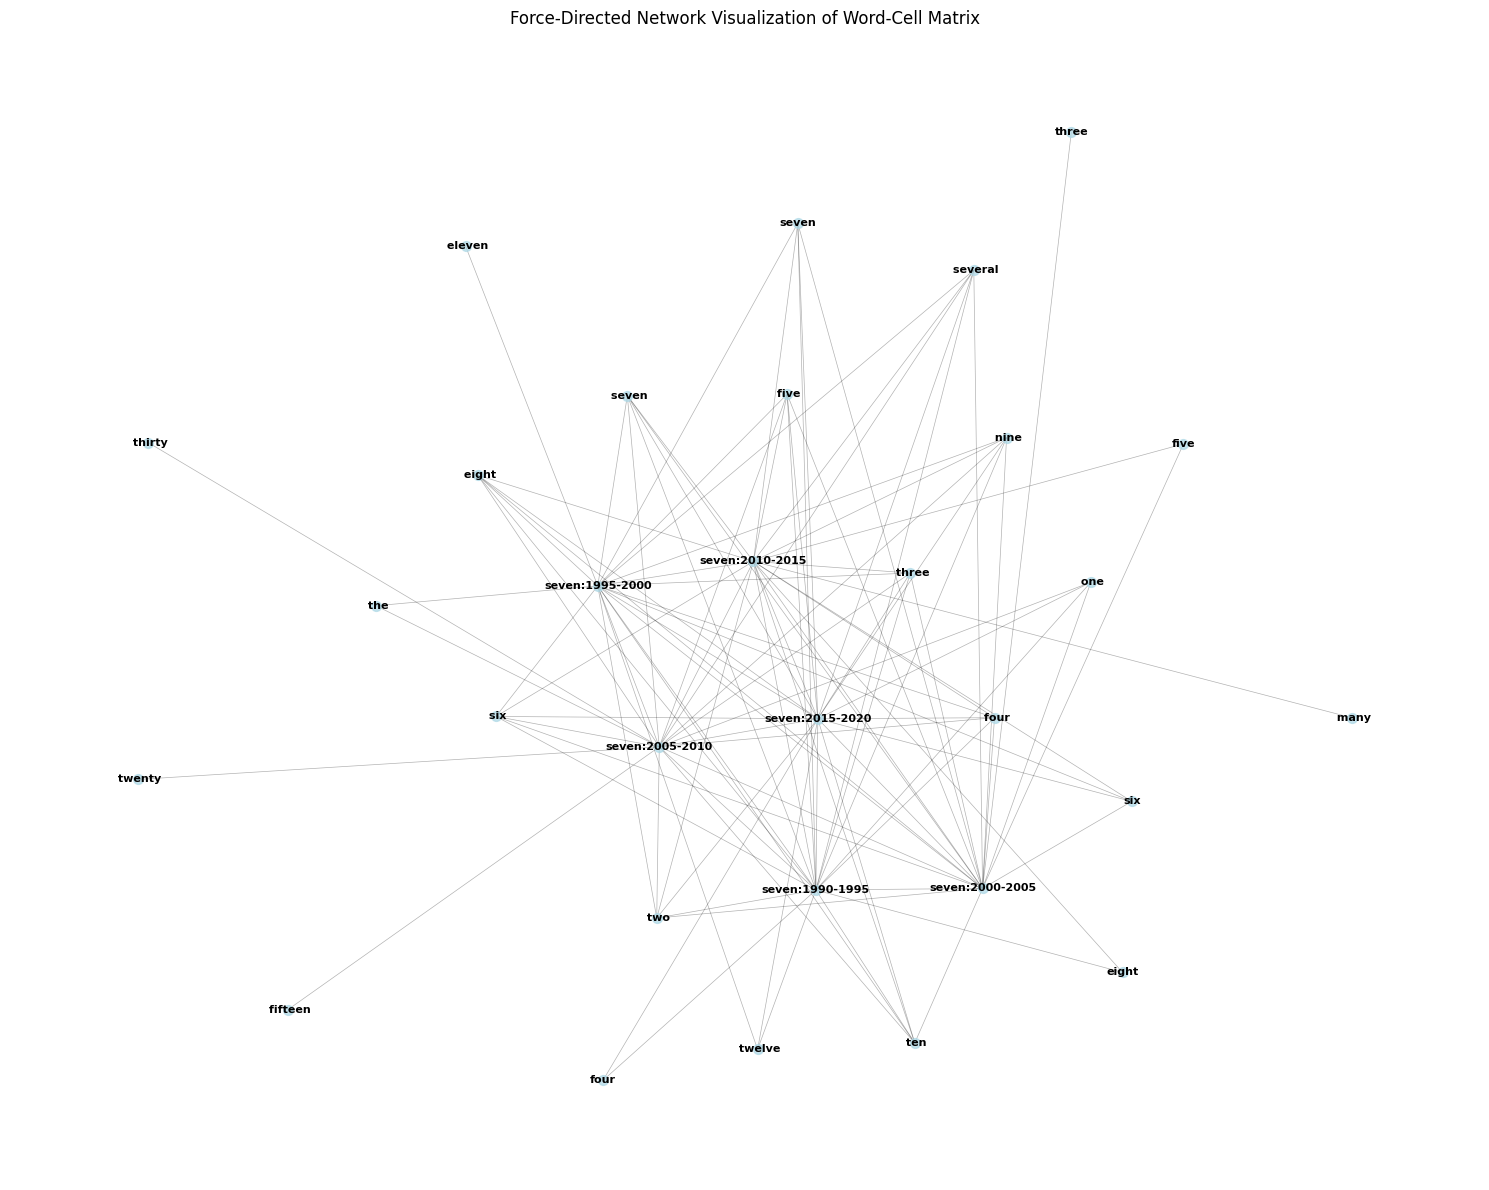

Wrote interactive ego-network HTML to: seven_network_plot.html


In [14]:
seven_G, seven_pos, seven_matrix = paradigmic_change('seven', 'mined_usages/seven_uses.txt', model, tokenizer, subset_size=300)

In [15]:
import networkx as nx

# Calculate modularity of the graph
cell_modularity = nx.community.modularity(cell_G, nx.community.greedy_modularity_communities(cell_G))
print(f"Modularity of the cell graph: {cell_modularity:.4f}")

seven_modularity = nx.community.modularity(seven_G, nx.community.greedy_modularity_communities(seven_G))
print(f"Modularity of the seven graph: {seven_modularity:.4f}")



Modularity of the cell graph: 0.1562
Modularity of the seven graph: 0.0254


Saved network comparison to paradigmic_networks_paper.png


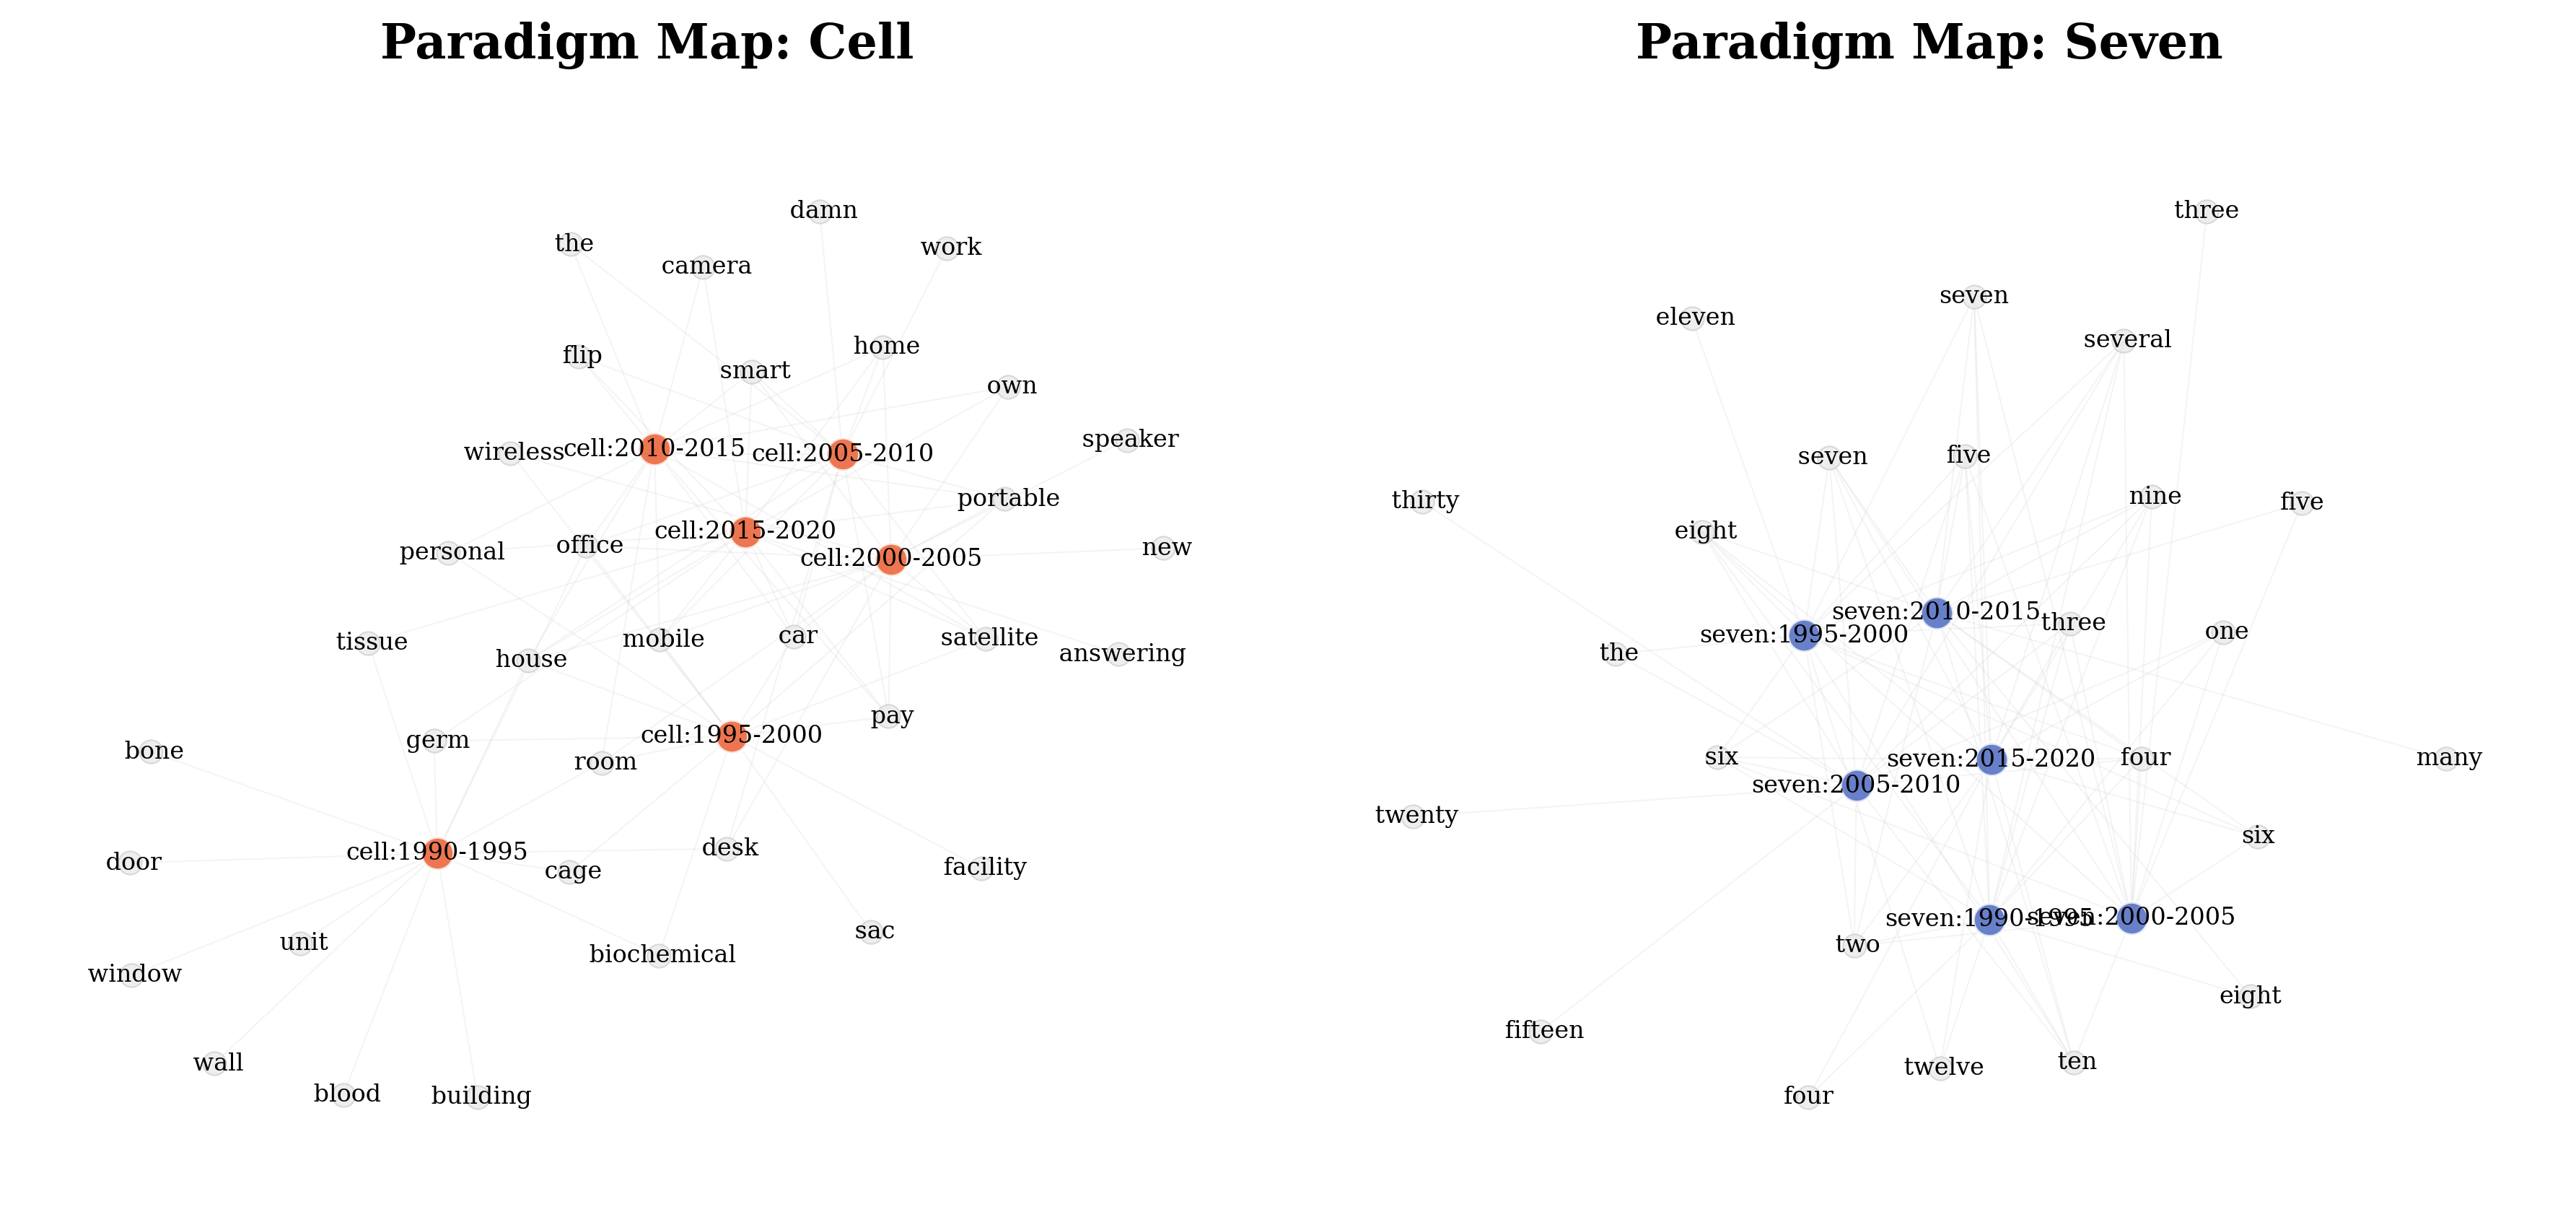

In [18]:
# Create a two-panel figure for the paper showing cell and seven network layouts
# Following the styling from climate_change.ipynb's visualize_process_small and bayes.ipynb paper figure

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import urllib.request
import matplotlib.font_manager as fm

# Download and set the Junicode font for consistency with paper styling
font_url = "http://calcifercomputing.com/fonts/junicode/TTF/Junicode-Regular.ttf"
font_path = "/tmp/Junicode-Regular.ttf"
try:
    urllib.request.urlretrieve(font_url, font_path)
    junicode_prop = fm.FontProperties(fname=font_path)
    junicode_available = True
except:
    junicode_available = False
    print("Could not download Junicode font, using serif fallback")

def create_paper_network_figure(cell_G, cell_pos, seven_G, seven_pos, saveas=None):
    """
    Create a two-panel network visualization following paper styling conventions.
    
    Args:
        cell_G: NetworkX graph for cell
        cell_pos: Position dictionary for cell nodes
        seven_G: NetworkX graph for seven  
        seven_pos: Position dictionary for seven nodes
        saveas: Optional filename to save PNG (without extension)
    """
    
    # Create figure optimized for manuscript use - two column layout
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=300)
    
    # Define consistent color palette matching paper styling
    good_colors = ['#EA5526', '#4462BD', '#51915B', '#8064A2', '#E5B700']
    
    # Left panel: Cell network
    # Draw edges with subtle styling
    nx.draw_networkx_edges(cell_G, cell_pos, ax=ax1, alpha=0.2, width=0.5, edge_color='#CCCCCC')
    
    # Identify cell time nodes and regular nodes
    cell_time_nodes = [n for n in cell_G.nodes() if 'cell:' in str(n)]
    cell_regular_nodes = [n for n in cell_G.nodes() if 'cell:' not in str(n)]
    
    # Draw time nodes with special styling (larger, colored)
    if cell_time_nodes:
        time_pos = {n: cell_pos[n] for n in cell_time_nodes}
        nx.draw_networkx_nodes(cell_G, time_pos, nodelist=cell_time_nodes, ax=ax1,
                              node_size=120, node_color=good_colors[0], alpha=0.8,
                              edgecolors='white', linewidths=1)
    
    # Draw regular nodes (smaller, neutral color)
    if cell_regular_nodes:
        regular_pos = {n: cell_pos[n] for n in cell_regular_nodes}
        nx.draw_networkx_nodes(cell_G, regular_pos, nodelist=cell_regular_nodes, ax=ax1,
                              node_size=60, node_color='#E8E8E8', alpha=0.7,
                              edgecolors='#CCCCCC', linewidths=0.5)
    
    # Draw labels with paper-appropriate font
    if junicode_available:
        nx.draw_networkx_labels(cell_G, cell_pos, ax=ax1, font_size=8, 
                               font_weight='normal', font_family='serif')
    else:
        nx.draw_networkx_labels(cell_G, cell_pos, ax=ax1, font_size=8,
                               font_weight='normal', font_family='serif')
    
    # Style left panel
    ax1.set_title('Paradigm Map: Cell', fontfamily='serif', fontsize=16, fontweight='bold', pad=20)
    ax1.axis('off')
    
    # Right panel: Seven network  
    # Draw edges with subtle styling
    nx.draw_networkx_edges(seven_G, seven_pos, ax=ax2, alpha=0.2, width=0.5, edge_color='#CCCCCC')
    
    # Identify seven time nodes and regular nodes
    seven_time_nodes = [n for n in seven_G.nodes() if 'seven:' in str(n)]
    seven_regular_nodes = [n for n in seven_G.nodes() if 'seven:' not in str(n)]
    
    # Draw time nodes with special styling (larger, colored)
    if seven_time_nodes:
        time_pos = {n: seven_pos[n] for n in seven_time_nodes}
        nx.draw_networkx_nodes(seven_G, time_pos, nodelist=seven_time_nodes, ax=ax2,
                              node_size=120, node_color=good_colors[1], alpha=0.8,
                              edgecolors='white', linewidths=1)
    
    # Draw regular nodes (smaller, neutral color)
    if seven_regular_nodes:
        regular_pos = {n: seven_pos[n] for n in seven_regular_nodes}
        nx.draw_networkx_nodes(seven_G, regular_pos, nodelist=seven_regular_nodes, ax=ax2,
                              node_size=60, node_color='#E8E8E8', alpha=0.7,
                              edgecolors='#CCCCCC', linewidths=0.5)
    
    # Draw labels with paper-appropriate font
    if junicode_available:
        nx.draw_networkx_labels(seven_G, seven_pos, ax=ax2, font_size=8,
                               font_weight='normal', font_family='serif')
    else:
        nx.draw_networkx_labels(seven_G, seven_pos, ax=ax2, font_size=8,
                               font_weight='normal', font_family='serif')
    
    # Style right panel
    ax2.set_title('Paradigm Map: Seven', fontfamily='serif', fontsize=16, fontweight='bold', pad=20)
    ax2.axis('off')
    
    # Add subtle background
    fig.patch.set_facecolor('white')
    
    # Tight layout to prevent clipping
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Make room for suptitle
    
    # Save as PNG if filename provided
    if saveas:
        if not saveas.endswith('.png'):
            saveas += '.png'
        plt.savefig(saveas, dpi=300, bbox_inches='tight', 
                   facecolor='white', edgecolor='none')
        print(f"Saved network comparison to {saveas}")
    
    plt.show()

# Create the paper figure
create_paper_network_figure(cell_G, cell_pos, seven_G, seven_pos, saveas='paradigmic_networks_paper')
